#  Mall Customer Segmentation

## Introduction:


The owner for a franchise mall reaches out to you as a Data Scientist to analyze their data to see how they can improve sales. Through the mall's annual membership cards, you have some general data about their shoppers that include Customer ID, age, gender, annual income and spending score. This looks to be a prime example for use of DBSCAN and K-means clustering, which will allow us to cluster groups and see how different factors interact. Spending Score is a rating that is assigned to each customer based on parameters that involve their spending habits. We want understand how customers converge and visualize spending habits. This will be exceedingly important for the marketing team to make data-driven choices and campaigns to target certain groups of shoppers. This notebook will go through the exploratory data analysis (EDA) procedure, model building and training, discussion, and conclusion.

The link to the Github notebook can be found [here.](https://github.com/aryanbashar/customer-segmentation)

#### Load in required packages:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading in the data
customer_data = pd.read_csv('/content/drive/MyDrive/DTSA/Mall_Customers.csv')

## Exploratory Data Analysis (EDA):

In [ ]:
# First 5 rows
customer_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


We can right away see that there is 5 columns of CustomerID, Gender, Age, Annual Income (k$), and Spending Score (1-100). Let's visualize some comparisons to see if there are any trends.

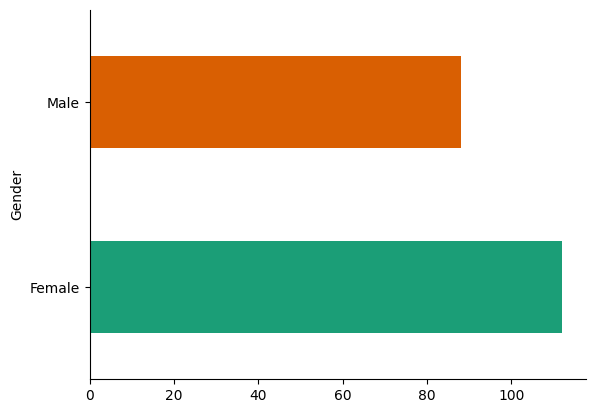

In [ ]:
# Gender
customer_data.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

There are more females with membership cards than males.

<ipython-input-9-7b8c9b7e06f0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(customer_data, x='Spending Score (1-100)', y='Gender', inner='stick', palette='Dark2')


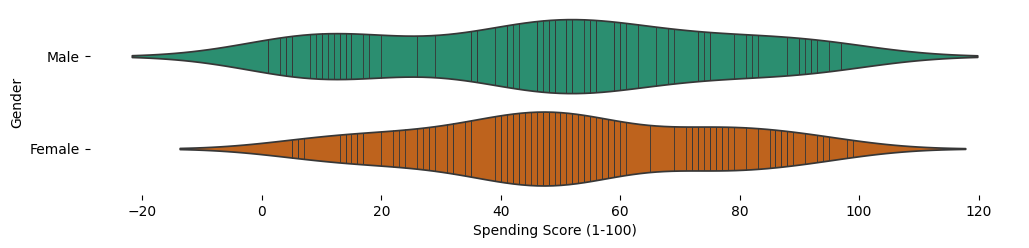

In [ ]:
# Gender vs Spending Score (1-100)

figsize = (12, 1.2 * len(customer_data['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(customer_data, x='Spending Score (1-100)', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

It seems that males may have a slightly higher average spending score than females.

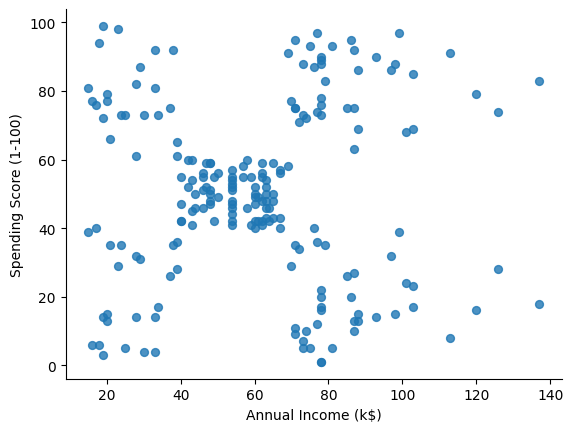

In [ ]:
# Annual Income (k$) vs Spending Score (1-100)

customer_data.plot(kind='scatter', x='Annual Income (k$)', y='Spending Score (1-100)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

There is potential for k-means clustering here, we can see the 5 groups.

A correlation matrix is useful for finding relationships between different variables. It can also help to see what variables we can use for further analysis. First, gender will need to be converted to numerical values for analysis.

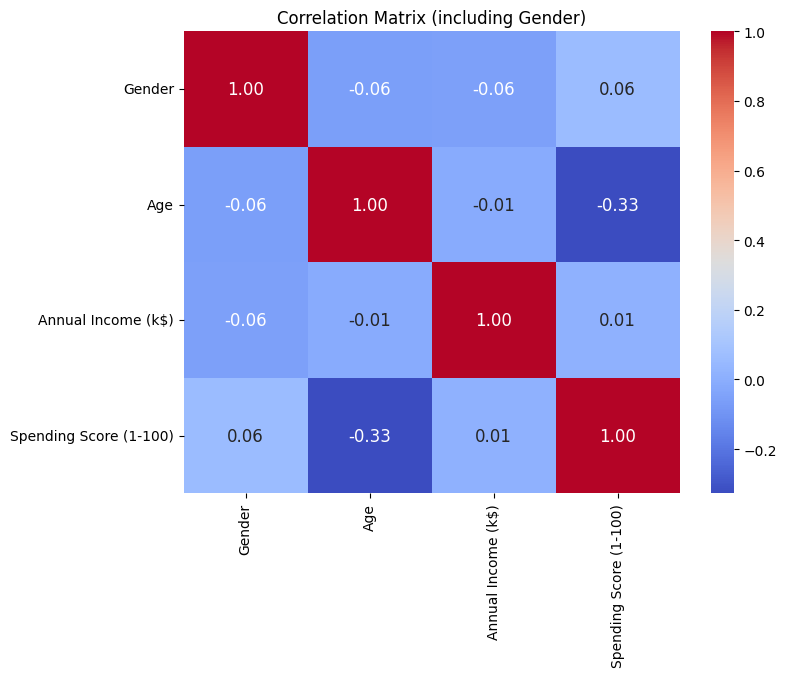

In [ ]:
# Convert 'Gender' column to numerical values
customer_data['Gender'] = customer_data['Gender'].map({'Male': 0, 'Female': 1})

# Select numerical columns (including 'Gender') for correlation analysis
numerical_columns_with_gender = customer_data[['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Compute the correlation matrix
correlation_matrix_with_gender = numerical_columns_with_gender.corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_with_gender, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
plt.title('Correlation Matrix (including Gender)')
plt.show()

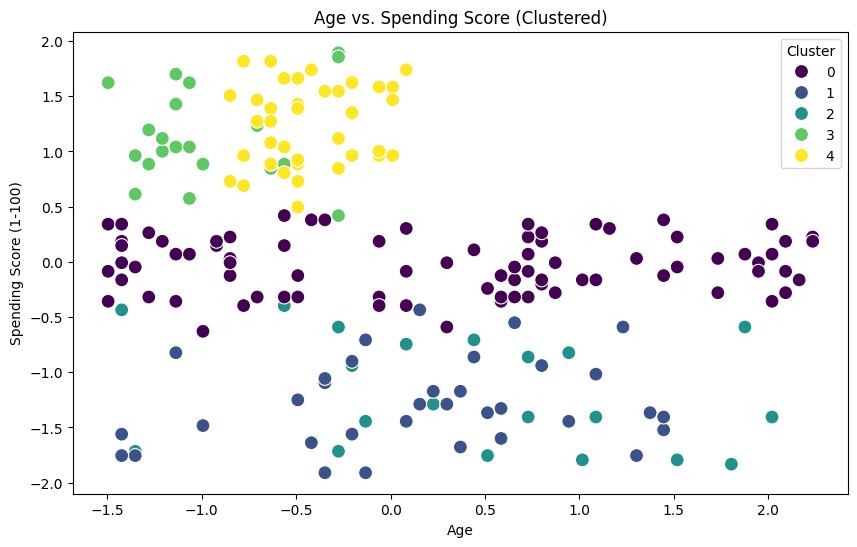

In [ ]:
# Visualize Age vs. Spending Score with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scaled_customer_data, x='Age', y='Spending Score (1-100)', hue='Cluster', palette='viridis', s=100)
plt.title('Age vs. Spending Score (Clustered)')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

Finally, let us check how our data looks and if there are any missing values or outliers to deal with.

In [ ]:
# Number of rows and columns
customer_data.shape

(200, 5)

In [ ]:
# Data Information
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
# Check for missing values
customer_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Outlier Checking and removal is important for optimal model performance. In this case, we select the columns that are required for detection and calculate the z score for each. An outlier is categorized as a values with an absolute z-score that is greater than 3. This is a threshold that highlights when a data point is far from the central tendency.

In [ ]:
# Select numerical columns for outlier detection and feature scaling
numerical_columns = customer_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Outlier detection using z-score
z_scores = (numerical_columns - numerical_columns.mean()) / numerical_columns.std()
outliers = (np.abs(z_scores) > 3).any(axis=1)

# Remove outliers
filtered_data = customer_data[~outliers]

#### Preprocessing:

Using StandardScaler, we can normalize the features of the data. There can be different scales and units in each category, so having a way to standardize is for the model is important. Especially for distance based algorithms like K-means clustering, the scale on features should be standardize to improve clustering results. It is seen that scaled features lead to better model performance on unseen data since the cohesion within clusters and the separation between them is improved. StandardScaler can also help with reaching convergence sooner since the optimizer works more efficiently when features are normalized. It is not as important for Density-Based Spatial Clustering of Applications with Noise (DBSCAN), which forms clusters based on areas of high-density compared to areas with lower density.  

In [ ]:
# Feature scaling using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(filtered_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

# Convert scaled features back to a DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])

# Concatenate scaled features with non-scaled columns (e.g., CustomerID, Gender)
scaled_customer_data = pd.concat([filtered_data[['CustomerID', 'Gender']], scaled_data], axis=1)

# Display scaled data
print(scaled_customer_data.head())

   CustomerID  Gender       Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male -1.424569           -1.738999               -0.434801
1           2    Male -1.281035           -1.738999                1.195704
2           3  Female -1.352802           -1.700830               -1.715913
3           4  Female -1.137502           -1.700830                1.040418
4           5  Female -0.563369           -1.662660               -0.395980


## Model Building and Training:

DBSCAN can be useful for segmenting mall customer spending data due to being useful when there are irregular shapes for the clusters. It is also helpful for noisy data, working well with limited or extreme spending habits in customers. Since it is density based, it can also identify groups of people with higher or lower spending habits which makes it flexible.

We can also graph the clusters after and calculate the Silhouette Score and Davis-Bouldin Index, which are both metrics for assessing the quality of clustering algorithms. A Silhouette Score ranges from -1 to 1, where a number closer to 1 would show that clusters are more dense and well-divided. The Davis-Bouldin Index instead determines the average concerning each cluster and its nearest cluster. Lower numbers confirm better clustering, with 0 being the lowest possible.

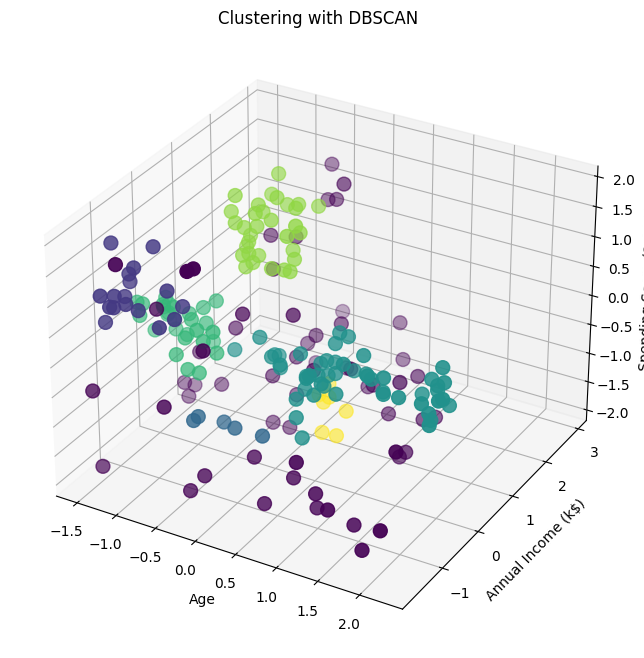

Silhouette Score: 0.18451372756506046
Davies-Bouldin Index: 1.7569458461701164


In [ ]:
# Select features for clustering (including 'Age', 'Annual Income', and 'Spending Score')
features_for_clustering = scaled_customer_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Create DBSCAN object
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit DBSCAN to the data and predict clusters
cluster_labels = dbscan.fit_predict(features_for_clustering)

# Add cluster labels to the dataframe
scaled_customer_data['Cluster'] = cluster_labels

# Visualize clusters (3D scatter plot)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(scaled_customer_data['Age'], scaled_customer_data['Annual Income (k$)'], scaled_customer_data['Spending Score (1-100)'],
           c=cluster_labels, cmap='viridis', s=100)

# Set labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('Clustering with DBSCAN')

plt.show()

# Calculate Silhouette Score
silhouette = silhouette_score(features_for_clustering, cluster_labels)
print("Silhouette Score:", silhouette)

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(features_for_clustering, cluster_labels)
print("Davies-Bouldin Index:", davies_bouldin)

The Silhouette Score is quite low, and the Davies-Bouldin Index is quite high. Let's see if we can improve it by removing one of the features.





Silhouette Score: 0.35044619989666004
Davies-Bouldin Index: 0.8285103931757107


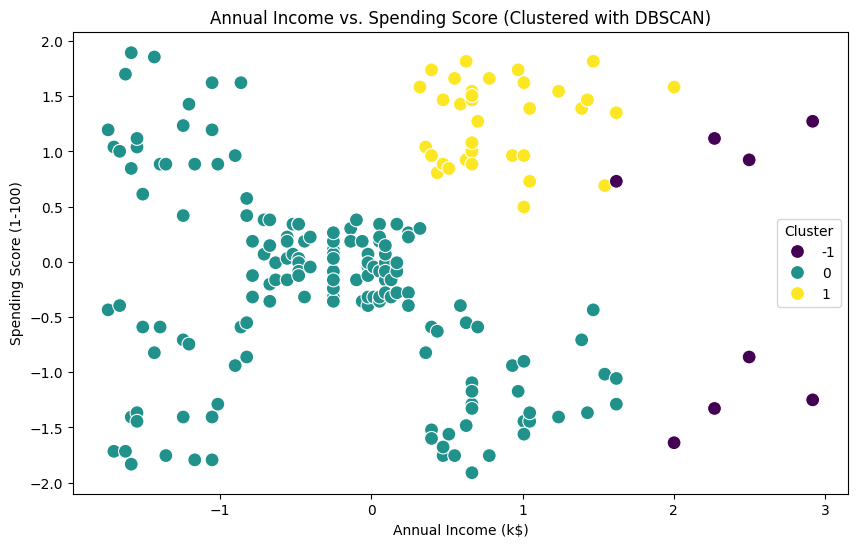

In [ ]:
# Select features for clustering (only 'Annual Income (k$)' and 'Spending Score (1-100)')
features_for_clustering = scaled_customer_data[['Annual Income (k$)', 'Spending Score (1-100)']]

# Create DBSCAN object
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit DBSCAN to the data and predict clusters
cluster_labels = dbscan.fit_predict(features_for_clustering)

# Add cluster labels to the dataframe
scaled_customer_data['Cluster'] = cluster_labels

# Calculate Silhouette Score
silhouette = silhouette_score(features_for_clustering, cluster_labels)
print("Silhouette Score:", silhouette)

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(features_for_clustering, cluster_labels)
print("Davies-Bouldin Index:", davies_bouldin)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scaled_customer_data, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis', s=100)
plt.title('Annual Income vs. Spending Score (Clustered with DBSCAN)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

To see how many clusters we should use for our models, we can use the Elbow Method. It uses a point called the within-cluster sum of squares (WCSS) which when it slows to a stable rate will show the best number of clusters for the dataset. It helps save time by rerunning models over with different amounts of clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

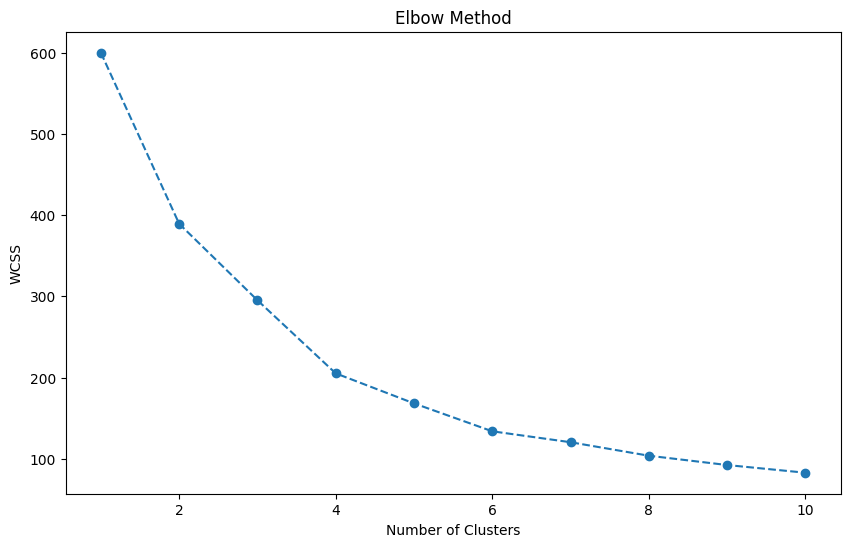

In [ ]:
# Select features for clustering
features_for_clustering = scaled_customer_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_for_clustering)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()

#### Second Model - K-means Clustering:

We can try k-means to see how to performs compared to DBSCAN. It has benefits in that k-means functions better when clusters are more spherical in the features.  It is easy to interpret as well since each cluster is produced by distinct centroids. A centroid is based on the nearest mean, and each data point would be placed in a cluster based on that. It is useful to use if you already know how many clusters to use, as we identified in the Elbow Method.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


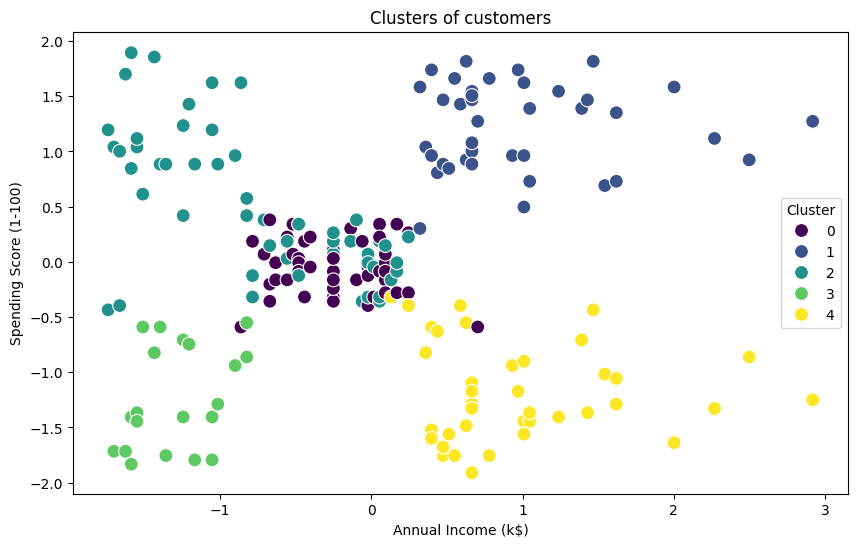

In [ ]:
# Apply K-means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(features_for_clustering)

# Add cluster labels to the dataframe
scaled_customer_data['Cluster'] = cluster_labels

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scaled_customer_data, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis', s=100)
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

We can display the clusters in a 3D model as well:

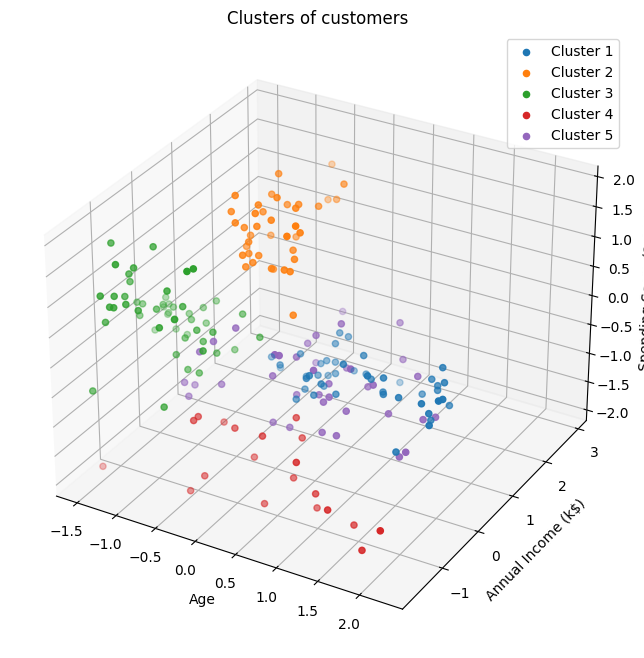

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster in range(5):
    cluster_data = scaled_customer_data[scaled_customer_data['Cluster'] == cluster]
    ax.scatter(cluster_data['Age'], cluster_data['Annual Income (k$)'], cluster_data['Spending Score (1-100)'], label='Cluster ' + str(cluster + 1))

# Set labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('Clusters of customers')

# Add legend
ax.legend()

plt.show()

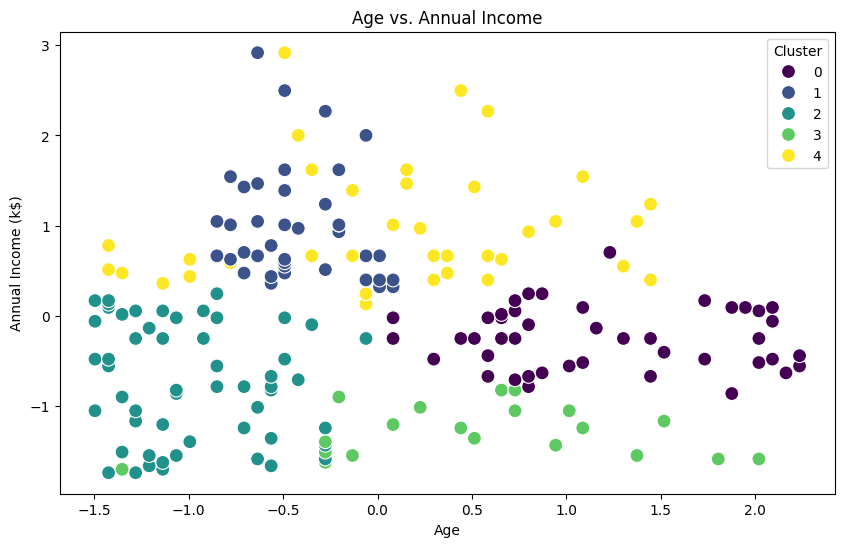

In [ ]:
# Scatter plot of Age vs. Annual Income
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scaled_customer_data, x='Age', y='Annual Income (k$)', hue='Cluster', palette='viridis', s=100)
plt.title('Age vs. Annual Income')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.legend(title='Cluster')
plt.show()

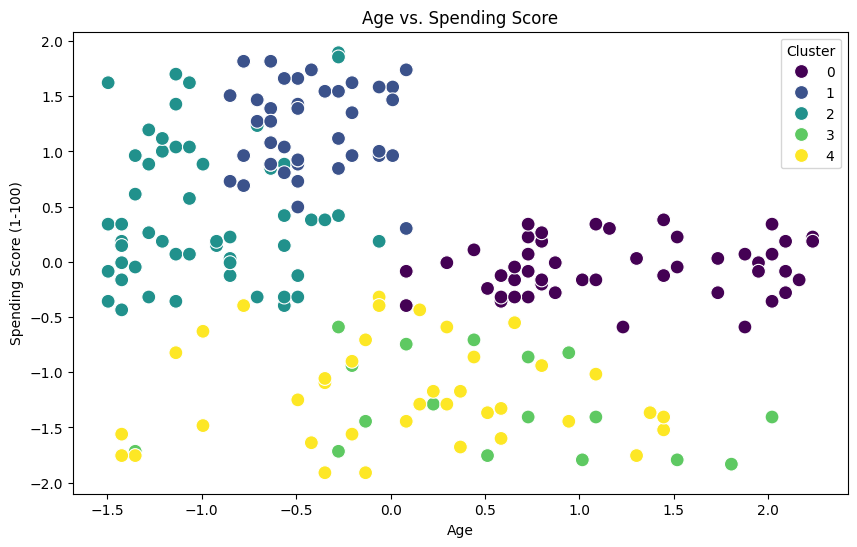

In [ ]:
# Scatter plot of Age vs. Spending Score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scaled_customer_data, x='Age', y='Spending Score (1-100)', hue='Cluster', palette='viridis', s=100)
plt.title('Age vs. Spending Score')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Calculate Silhouette Score
silhouette = silhouette_score(features_for_clustering, cluster_labels)
print("Silhouette Score:", silhouette)

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(features_for_clustering, cluster_labels)
print("Davies-Bouldin Index:", davies_bouldin)


Silhouette Score: 0.41664341513732767
Davies-Bouldin Index: 0.874551051002418


The Silhouette Score went up, but the Davies-Bouldin Index went up as well. Hyperparameter tuning will be required to further improve the model.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

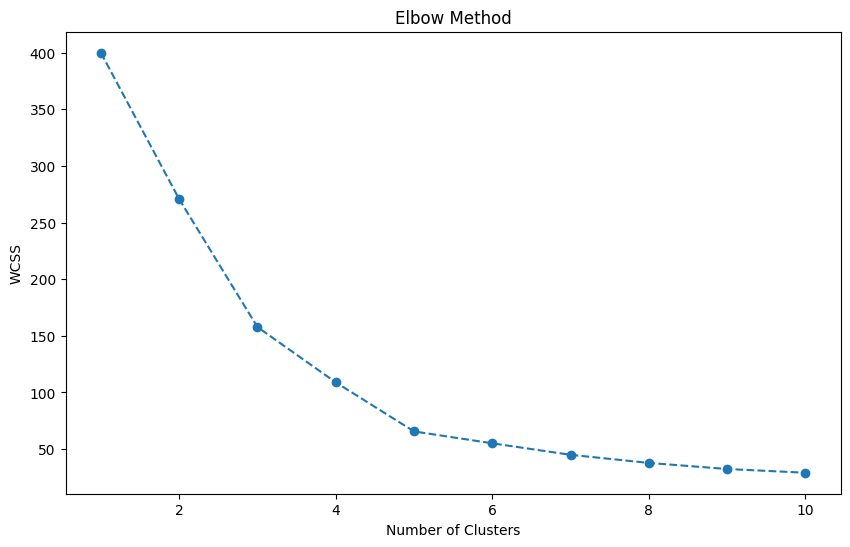

In [ ]:
# Select features for clustering (only 'Annual Income (k$)' and 'Spending Score (1-100)')
features_for_clustering = scaled_customer_data[['Annual Income (k$)', 'Spending Score (1-100)']]

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_for_clustering)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


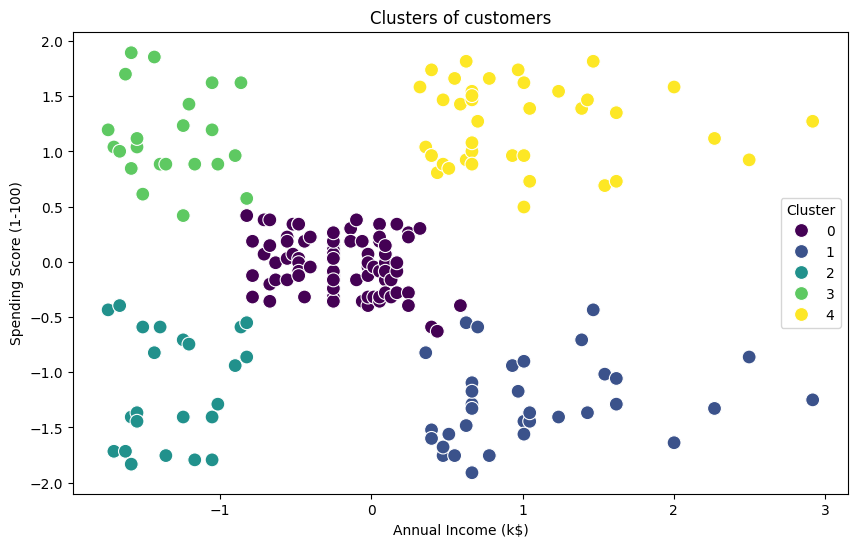

In [ ]:
# From the Elbow Method, we observe that the elbow point is around 5 clusters

# Apply K-means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(features_for_clustering)

# Add cluster labels to the dataframe
scaled_customer_data['Cluster'] = cluster_labels

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scaled_customer_data, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis', s=100)
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Calculate Silhouette Score
silhouette = silhouette_score(features_for_clustering, cluster_labels)
print("Silhouette Score:", silhouette)

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(features_for_clustering, cluster_labels)
print("Davies-Bouldin Index:", davies_bouldin)

Silhouette Score: 0.5546571631111091
Davies-Bouldin Index: 0.5722356162263352


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

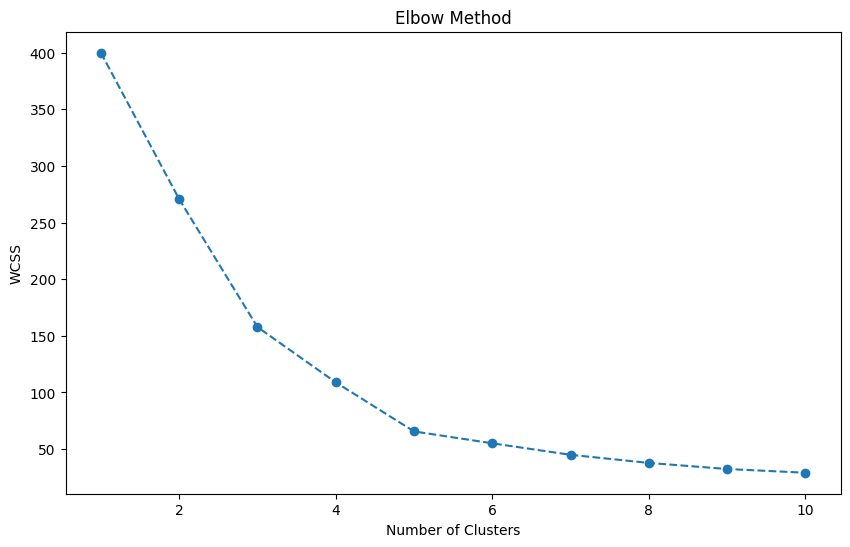

In [ ]:
# Select features for clustering (only 'Annual Income (k$)' and 'Spending Score (1-100)')
features_for_clustering = scaled_customer_data[['Annual Income (k$)', 'Spending Score (1-100)']]

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    # Adjust the max_iter parameter here
    max_iter = 500  # Adjust as needed

    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=max_iter, random_state=42)
    kmeans.fit(features_for_clustering)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

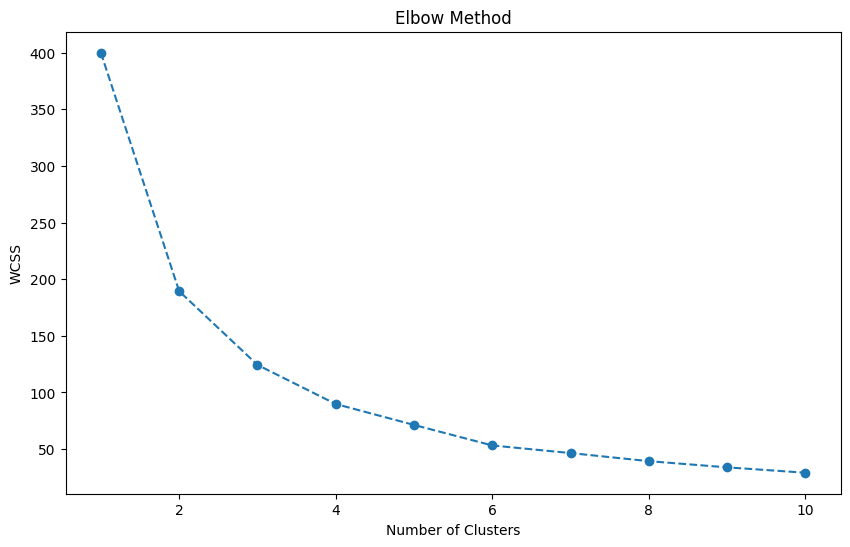

In [ ]:
# Select features for clustering (only 'Age' and 'Spending Score (1-100)')
features_for_clustering = scaled_customer_data[['Age', 'Spending Score (1-100)']]

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_for_clustering)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


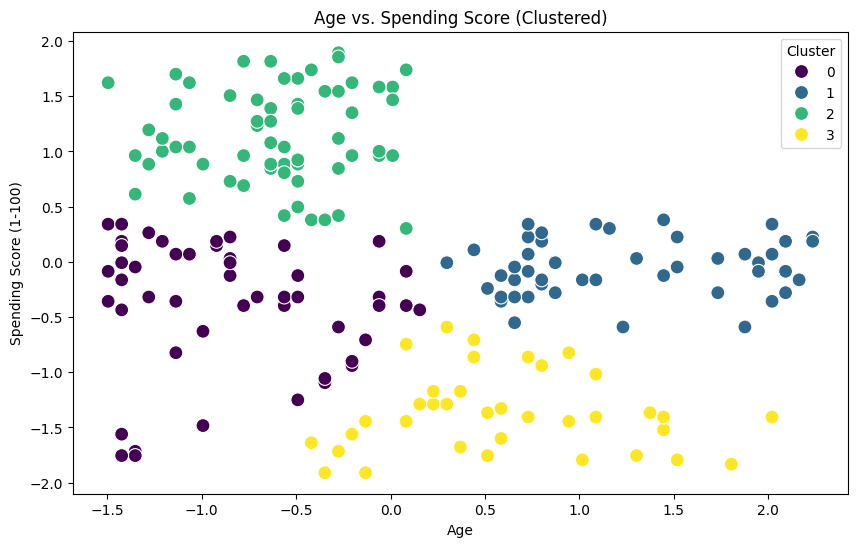

In [ ]:
# From the Elbow Method, we observe that the elbow point is around 4 clusters

# Apply K-means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(features_for_clustering)

# Add cluster labels to the dataframe
scaled_customer_data['Cluster'] = cluster_labels

# Visualize Age vs. Spending Score with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scaled_customer_data, x='Age', y='Spending Score (1-100)', hue='Cluster', palette='viridis', s=100)
plt.title('Age vs. Spending Score (Clustered)')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Calculate Silhouette Score
silhouette = silhouette_score(features_for_clustering, cluster_labels)
print("Silhouette Score:", silhouette)

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(features_for_clustering, cluster_labels)
print("Davies-Bouldin Index:", davies_bouldin)

Silhouette Score: 0.4383860846531993
Davies-Bouldin Index: 0.8244059418428444


## Results Summary:
-------------------------------------------------------------
*  **K-Means** Silhouette Score: 0.5546571631111091
*   **K-Means** Davies-Bouldin Index: 0.5722356162263352
------------------------------------------------------------
*   **DBSCAN** Silhouette Score: 0.35044619989666004
*   **DBSCAN** Davies-Bouldin Index: 0.8285103931757107

-------------------------------------------------------------

## Discussion:

Based on the measurements of Silhouette Score and Davies-Bouldin Index, it is seen that the K-Means clustering algorithm performed better than DBSCAN. A higher value for the Silhouette Score indicates that the object is well matched to its cluster and not matched well with other clusters. A score of about 0.5547 indicates a relatively strong separation and cohesion between and within the clusters. Davies-Bouldin Index is a measure of cluster quality, and a lower score would show that clusters are separated well. The K-means algorithm had a 0.5722 which is much lower than the 0.8285 of DBSCAN, which signifies that the K-means clusters had good separation and compactness.

To decipher why K-means performed better for this dataset, we need to discuss the strengths and weaknesses of both algorithms. K-means usually performs quite well for customer segmentation analysis, and this is partially due to the clusters being hyper-spherical and can form around centroids based on a multitude of features like income, spending score, and age.  Likewise, K-means works best when features are on a similar standardization or normalization. The data was preprocessed using StandardScaler which normalizes the various features in the data, which is not as important for DBSCAN. Another aspect in the exploratory data analysis phase was the removal of outliers. DBSCAN has a robust system in place that helps lessen the emphasis of outliers on the final performance, but since outliers were removed the benefit goes to K-means. Also, since the elbow method was used to find the optimal number of clusters, this helps K-means since the parameters of DBSCAN are not straightforward in their presentation. Overall, there were many aspects that aided the performance of K-means that was not provided directly for DBSCAN.

Through the clusters of the Spending Score and Annual Income plot, we can see that there are 5 different clusters that can be targeted for marketing. The aim would be to market for the group that has a low annual income but increased spending habits and the group with high annual income and high spending score.  When looking at age against spending score, we would want to target the younger group of customers in cluster 2 that have high spending scores compared to the rest.


## Future Steps:



1.   Further Data Sources
  - Include more demographic data with various details regarding customer spending.
  - Analyze history of transactions to find patterns in product preferences, trends in time, and number of items purchased.

2.   Cluster Analysis
  - Use these updated customer profiles to separate them through characteristics, preferences, and behaviors to understand shopping habits.
  - Bring about other statistical techniques to measure cluster performance.

3. Marketing
  - Use the results to develop marketing campaigns that target the clusters of shoppers and benefit their buying habits.
  - Test different strategies and compare to find the best options that improve sales.  

## Conclusion:

The study into mall customer segmentation has provided the opportunity to utilize unsupervised learning techniques like DBSCAN and K-means to advance our knowledge of the diverse shoppers and their spending habits. There was careful preparation done to preprocess the data through outlier removal and feature standardization prior to modeling. The use of K-means clustering provided the ideal system for segmentation of the customer base. These results not only show the benefit of utilizing algorithms to make data-driven decisions, but also the ability to stand at the forefront of technology to provide customers with the best experience imaginable.  

## References:

*Mall Customer Segmentation data.* (2018, August 11). Kaggle. https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data

Schubert, E., Sander, J., Ester, M., Kriegel, H. P., & Xu, X. (2017). DBSCAN revisited, revisited: why and how you should (still) use DBSCAN. *ACM Transactions on Database Systems* (TODS), 42(3), 1-21.

Xu, D., & Tian, Y. (2015). A comprehensive survey of clustering algorithms. *Annals of data science*, 2, 165-193.